<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/Lab2_DL_parts_4_and_5_optional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
from time import time
from IPython.display import clear_output
from tqdm import tqdm
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip Dataset.zip

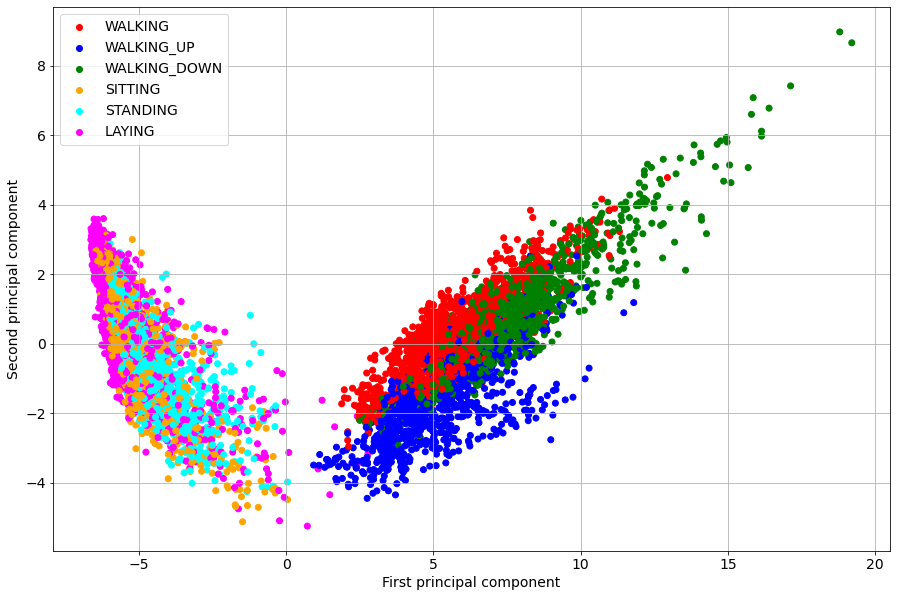

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING_UP", "WALKING_DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i) - 1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize = (15, 10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c = mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c = colors_list[idx], 
                label = legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]
print("We have # {} labels over here".format(len(LABELS)))

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        X_signals.append(
            [np.array(serie, dtype = np.float32) \
             for serie in [row.replace('  ', ' ').strip().split(' ') for row in file]])
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [os.path.join(*[DATASET_PATH, TRAIN, \
                    "Inertial Signals/", signal + "train.txt"]) for signal in INPUT_SIGNAL_TYPES]

X_test_signals_paths = [os.path.join(*[DATASET_PATH, TEST, \
                    "Inertial Signals/", signal + "test.txt"]) for signal in INPUT_SIGNAL_TYPES]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file]], dtype = np.int32)
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

We have # 6 labels over here

Dataset is now located at: ./UCI HAR Dataset/


In [ ]:
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep
n_classes = 6 # Total classes (should go up, or should go down)

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $ = $86% - 2 points
* $\geq $89% - 2.5 points
* $\geq $91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

### Dataset descripton:

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used


In [ ]:
# Your experiments here
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary

def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

class SignalSet(Dataset):
    def __init__(self, data, labels, transforms = None):
        """
        1) data shape should be (#series, #timesteps_per_series, #input_params_per_timestep)
        2) torch audio transorms if needed 
        """
        def one_hot_encode(labels, n_classes = 6):
            return np.eye(n_classes)[np.array(labels.reshape(len(labels)))]
        
        self.X = torch.FloatTensor(data)
        self.y = torch.LongTensor(one_hot_encode(labels))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.X[idx]; label = self.y[idx] 
        if self.transforms:
            sample = self.transforms(sample)
        return sample, label
    
train_set, valid_set = test_train_split(SignalSet(X_train, y_train), .75)
test_set = SignalSet(X_test, y_test)

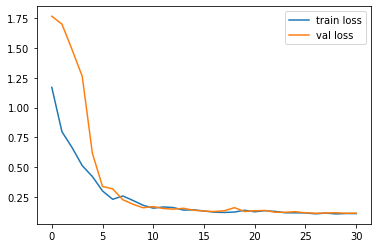

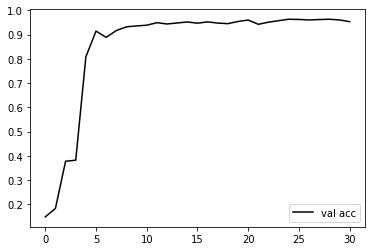

Epoch #31 toook 6.131 secs
	 val loss: 0.112
	 val acc: 0.956
	 train loss: 0.110
Epoch #32 toook 6.161 secs
	 val loss: 0.123
	 val acc: 0.957
	 train loss: 0.103
Test acc is  0.9127  %


In [ ]:
class ModelCNN(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size):
        super(ModelCNN, self).__init__()
        self.ic = input_channels
        self.oc = output_channels
        self.kernel_size = kernel_size

        #one or two convolutional blocks, ? average pooling
        self.conv1 = nn.Conv1d(self.ic, self.oc, self.kernel_size, stride = 1, padding = 1)
        self.act1 = nn.ReLU()     
        #need a bn after to scale inputs
        self.bn1 = nn.BatchNorm1d(self.oc)
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        return self.bn1(x)

class ModelLSTM(nn.Module):
    def __init__(self, input_dim,  n_layers, hidden_dim, n_classes):
          super(ModelLSTM, self).__init__()
          self.n_layers = n_layers
          self.hidden_dim = hidden_dim
          self.input_dim = input_dim
          self.num_classes = n_classes


          # just a stack of LSTM cells
          self.lstm = nn.LSTM(num_layers = self.n_layers, 
                              input_size = self.input_dim,
                              hidden_size = self.hidden_dim,
                              dropout = .5,
                              batch_first = True)
          #it is rather dangerous over here but i wonder it works pretty well
          self.bn1 = nn.BatchNorm1d(128)

          self.last_layer = nn.Linear(self.hidden_dim, n_classes)
    def forward(self, x):
          x, _ = self.lstm(x)
          x = self.bn1(x)
          x = self.last_layer(x)
          return x

class CombinedModel(nn.Module):
    def __init__(self):
          super(CombinedModel, self).__init__()
          self.cnn = ModelCNN(input_channels = n_input,
                              output_channels = 4 * n_input,
                              kernel_size = 3).to(device)
          #to conjugate dims i needed to find a proper kernel size                   
          self.lstm = ModelLSTM(input_dim = self.cnn.oc, 
                    n_layers = 2, hidden_dim = 513,
                    n_classes = n_classes).to(device)

    def forward(self, x):
          batch_size, timesteps, n_c = x.size()
          c_in = x.transpose(1, 2)
          c_out = self.cnn(c_in)
          r_in = c_out.view(batch_size, timesteps, -1)
          r_out = self.lstm(r_in)
          return r_out

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = CombinedModel() 

train_history, val_history = [], []
val_accuracy = []

batch_size = 600
#just to save my time
n_epochs = 33

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

loss_fn = nn.CrossEntropyLoss()
#using exponential moving average for better convergence
opt = torch.optim.Adam(model.parameters(), lr =  5. * 1e-4, amsgrad = True)

for epoch in range(n_epochs):
    ep_train_history = []
    ep_val_history = []
    ep_val_accuracy = []
    
    _ = model.train(True)
    start_time = time()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        opt.zero_grad()

        out = model(X_batch)
        loss = loss_fn(out[:, -1].contiguous(), y_batch.contiguous().max(1)[1])
        loss.backward()
        opt.step()

        ep_train_history.append(loss.item())

    _ = model.eval()
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            out = model(X_batch)

            loss = loss_fn(out[:,-1].contiguous(), y_batch.contiguous().max(1)[1])
            ep_val_accuracy.append(np.mean(out[:, -1].max(1)[1].cpu().numpy() == y_batch.max(1)[1].cpu().numpy()))
            ep_val_history.append(loss.item())

    train_history.append(np.mean(ep_train_history))
    val_history.append(np.mean(ep_val_history))
    val_accuracy.append(np.mean(ep_val_accuracy))

    dur = time() - start_time

    print(f"Epoch #{epoch} toook {dur:.3f} secs")
    print(f"\t val loss: {val_history[-1]:.3f}")
    print(f"\t val acc: {val_accuracy[-1]:.3f}")
    print(f"\t train loss: {train_history[-1]:.3f}")

    if epoch % 5 == 0:
        clear_output()
        #plotting accuracies and losses
        plt.plot(train_history, label = "train loss")
        plt.plot(val_history, label = "val loss")
        plt.legend(loc = 'best')
        plt.show()
        plt.plot(val_accuracy, label = "val acc", color = "k")
        plt.legend(loc = 'best')
        plt.show()


test_accuracy = []

_ = model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(X_batch)
        test_accuracy.append(np.mean(out[:, -1].max(1)[1].cpu().numpy() == y_batch.max(1)[1].cpu().numpy()))

print("Test acc is ", round(np.mean(test_accuracy), 4), " %")

In [ ]:
from sklearn.metrics import classification_report
with torch.no_grad(): y_pred = model(torch.FloatTensor(X_test).to(device))[:, -1].max(1)[1].cpu().numpy()

def one_hot_encode(labels, n_classes = 6): return np.eye(n_classes)[np.array(labels.reshape(len(labels)))]
print(classification_report(y_test.ravel(), y_pred, target_names = LABELS))

                    precision    recall  f1-score   support

           WALKING       0.98      0.97      0.98       496
  WALKING_UPSTAIRS       0.93      0.97      0.95       471
WALKING_DOWNSTAIRS       0.94      0.91      0.92       420
           SITTING       0.78      0.84      0.81       491
          STANDING       0.88      0.79      0.83       532
            LAYING       0.96      1.00      0.98       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



In [ ]:
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)
_ = save_net(model, "Model.net", opt)

В работе над данным подходом я, прежде всего, ориентировался не та то, чтобы набить самый лучший результат, а на том, чтобы научиться построить сложную, комбинированную сеть.

В результате, можно выделить такие следующие этапы работы:
* был написал кастомный датасет для торча;
* создана моделька, состоящая из простой свёртки, чтобы увеличить размер прзнакового пространства $-$ вывернуть признаки наружу, которые потом были скормлены простой LSTM. Добавлены нормализации по батчам между сетями и между сетью и выходом;
* все гиперпараметры подобраны при помощи крутого метода тюнинга, который можно назвать греческим словом "дихотомия".  

Как видно из результатов, модель достаточно неплохо предсказывает данные с точностью (`accuracy`) чуть более 91%. Но модели сложно понять сидит человек или стоит, что показывает недостаток 'LSTM' $-$ ей сложно в статике. У `CNN` был бы другой недостаток, ей было бы сложно определить, идёт человек вверх или вниз. Возможно, если добавить больше свёрток, то что-то изменится.